
# **A Graph Neural Network as a Classifier for trees, using XRules dataset**

# **Installing Dependencies**

Installing torch_geometric library for GNN, and networkx library for checking if our custom graphs is created correctly.


In [ ]:
!pip install torch_geometric
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00


# **Project Dataset File**

Using us1924.asc file from XRules real data

In [ ]:
# PROJECT_TRAIN_DATA='/content/drive/MyDrive/Graph-Neural-Network/Synth-Data/DS3.train.asc'
# PROJECT_TEST_DATA='/content/drive/MyDrive/Graph-Neural-Network/Synth-Data/DS2.test.asc'
PROJECT_TRAIN_DATA= '/content/drive/MyDrive/Graph-Neural-Network/Real-Data/cslog1/cslog1.asc'
# PROJECT_TEST_DATA='/content/drive/MyDrive/Graph-Neural-Network/Real-Data/us2430/us2430.asc'

Reading Data from PROJECT_DATA and storing the lines in trees list

In [ ]:
train_file = open(PROJECT_TRAIN_DATA, 'r')
train_trees = train_file.readlines()

# test_file = open(PROJECT_TEST_DATA, 'r')
# test_trees = test_file.readlines()

# **Preprocessing Data and Creating Graph object for every Tree**

In [ ]:
# importing necessary modules
import numpy as np
import torch
import tensorflow as tf
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.utils as utils
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import torch_geometric as tg

train_dataset = []
edu = 0



for tree in train_trees:
  # removing '\n' from end of tree data
  tree = tree.removesuffix('\n')
  # splitting each tree data by space
  tree = tree.split(' ')
  # the first entry is the tree label
  tree_label = tree[0]

  if tree_label == '1':
    edu += 1
  # the second entry is the tree id
  tree_id = tree[1]
  # the third entry is the tree sequence length
  tree_len = tree[3]
  # the rest is the tree sequence
  tree_struct = tree[4:]

  # a list for containing the nodes of each tree
  nodes = []
  # a stack for traversing the tree and getting the edges of graph
  stack = []
  # two lists for storing the edges in COO format
  edges_row = []
  edges_col = []
  for s in tree_struct:
    if s != '-1' and int(s) not in nodes:
      nodes.append(int(s))

  for s in tree_struct:
    if s != '-1':
      stack.append(int(s))
      if len(stack) >= 2:
        stack_len = len(stack)
        edges_row.append(nodes.index(stack[stack_len - 2]))
        edges_col.append(nodes.index(stack[stack_len - 1]))
    else:
      stack.pop()

  node_array = []
  for n in nodes:
    temp = []
    temp.append(n)
    node_array.append(temp)
  final_nodes = np.array(node_array)
    # Assuming final_nodes is your existing tensor
  final_nodes = torch.tensor(final_nodes, dtype=torch.float)

  # Get the shape of the existing tensor
  original_shape = final_nodes.shape

  # Create a column vector of zeros with the same number of rows as final_nodes
  zeros_column = torch.zeros(original_shape[0], 1)

  # Concatenate the original tensor with the column of zeros along the second dimension (axis 1)
  final_nodes_with_zeros = torch.cat([final_nodes, zeros_column], dim=1)
  # embeddings = torch.tensor(final_nodes_with_zeros, dtype=torch.float)
  embeddings = torch.tensor(final_nodes, dtype=torch.float)


  y = torch.tensor([int(tree_label)])

  rows = np.array(edges_row)
  cols = np.array(edges_col)
  edges = torch.tensor([rows, cols], dtype=torch.long)
  undirected_edges = utils.to_undirected(edges)

  # creating the DATA object based on embeddings and edges and adding it to the dataset list
  train_dataset.append(Data(x=embeddings ,edge_index=edges, y=y))

print(train_dataset[30]['x'])
print(train_dataset[30]['edge_index'])
# print(train_dataset[0].is_undirected())
print(len(train_dataset))



<ipython-input-4-63af9e1b6255>:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(final_nodes, dtype=torch.float)
<ipython-input-4-63af9e1b6255>:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  edges = torch.tensor([rows, cols], dtype=torch.long)


tensor([[    0.],
        [20349.],
        [20354.],
        [20368.]])
tensor([[0, 1, 1],
        [1, 2, 3]])
8074


calculating number of children of each node, normalization method 2

In [ ]:
import numpy as np
import torch


# Step 1: Extract unique features for both features
unique_features1 = set()
# unique_features2 = set()
for graph in train_dataset:
    for node in graph['x']:
        unique_features1.add(node[0].item())  # Convert tensor to Python float
        # unique_features2.add(node[1].item())  # Convert tensor to Python float

# Step 2: Create dictionaries mapping features to integer indices for both features
feature_to_index1 = {feature: i for i, feature in enumerate(unique_features1)}
# feature_to_index2 = {feature: i for i, feature in enumerate(unique_features2)}

# Step 3: Apply one-hot encoding for both features
encoded_data = []
for graph in train_dataset:
    encoded_graph = []
    for node in graph['x']:
        # Create one-hot encoded vectors for both features
        one_hot_vector1 = np.zeros(len(unique_features1))
        # one_hot_vector2 = np.zeros(len(unique_features2))
        feature_index1 = feature_to_index1[node[0].item()]  # Convert tensor to Python float
        # feature_index2 = feature_to_index2[node[1].item()]  # Convert tensor to Python float
        one_hot_vector1[feature_index1] = 1
        # one_hot_vector2[feature_index2] = 1
        # Concatenate one-hot vectors for both features
        # encoded_node = np.concatenate([one_hot_vector1, one_hot_vector2])
        # encoded_graph.append(encoded_node)
        encoded_graph.append(one_hot_vector1)
    encoded_data.append(encoded_graph)

# Now, encoded_data contains your dataset with one-hot encoded features for both feature1 and feature2
print(len(encoded_data))
print(len(train_dataset[32].x))
print(encoded_data[32][0])
print(len(encoded_data[32][0]))

8074
5
[1. 0. 0. ... 0. 0. 0.]
9061


In [ ]:
print(train_dataset[32])
print(train_dataset[32].x)
print(train_dataset[32].edge_index)
print(train_dataset[32].y)
print(train_dataset[32].is_undirected)

final_train_dataset = []
print(type(encoded_data[32][0]))
for i in range(0, len(train_dataset)):
  graph = train_dataset[i]
  embeddings = []
  for j in range(0, len(graph['x'])):
    # Concatenate 492 zeros to the array
    # num_zeros = 491
    num_zeros = 0
    zeros_to_concatenate = np.zeros(num_zeros)
    concatenated_array = np.concatenate([encoded_data[i][j], zeros_to_concatenate])
    embeddings.append(concatenated_array)
  final_embeddings = torch.tensor(embeddings, dtype=torch.float)
  final_train_dataset.append(Data(x=final_embeddings ,edge_index=graph.edge_index, y=graph.y))

print(len(final_train_dataset))
print(final_train_dataset[32])
print(final_train_dataset[32].x)
print(final_train_dataset[32].edge_index)
print(final_train_dataset[32].y)
print(final_train_dataset[32].is_undirected)


Data(x=[5, 1], edge_index=[2, 4], y=[1])
tensor([[    0.],
        [12811.],
        [20351.],
        [37409.],
        [37411.]])
tensor([[0, 1, 0, 3],
        [1, 2, 3, 4]])
tensor([1])
<bound method BaseData.is_undirected of Data(x=[5, 1], edge_index=[2, 4], y=[1])>
<class 'numpy.ndarray'>
8074
Data(x=[5, 9061], edge_index=[2, 4], y=[1])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0, 1, 0, 3],
        [1, 2, 3, 4]])
tensor([1])
<bound method BaseData.is_undirected of Data(x=[5, 9061], edge_index=[2, 4], y=[1])>


In [ ]:
import torch
from torch_geometric.data import Data


# Step 1: Compute the number of children for each node in each graph
def compute_num_children(data):
    num_nodes = data.x.size(0)
    num_children = torch.zeros(num_nodes)
    for edge in data.edge_index.T:
        parent, child = edge
        num_children[parent] += 1
    return num_children

# Step 2: Calculate the global sum of the number of children across all graphs
global_sum = 0.0

num_children_list = []

for data in final_train_dataset:
    num_children = compute_num_children(data)
    num_children_list.append(num_children)
    global_sum += num_children.sum().item()

print(f"Global sum of node children: {global_sum}")


# Step 3: Normalize the number of children and add as a node feature
def normalize_and_add_feature(data, global_sum):
    num_children = compute_num_children(data)
    if global_sum > 0:  # Avoid division by zero
        num_children = num_children / global_sum
    else:
        num_children = torch.zeros_like(num_children)  # All nodes have the same number of children
    num_children = num_children.view(-1, 1)
    data.x = torch.cat([data.x, num_children], dim=1)
    return data

# Apply normalization and add the feature to each graph in the dataset
final_train_dataset = [normalize_and_add_feature(data, global_sum) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[30].x)

Global sum of node children: 56789.0
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.7609e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.5218e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


calculating number of children of each node, normalization method 1

calculating number of children of each node, no normaliztion



In [ ]:
import torch
from torch_geometric.data import Data
from collections import deque

# Define a function to compute the depth of each node
def compute_node_depth(data):
    num_nodes = data.x.size(0)
    depth = -torch.ones(num_nodes)  # Initialize depths with -1
    depth[0] = 0  # Assume node 0 is the root
    queue = deque([0])

    while queue:
        node = queue.popleft()
        current_depth = depth[node]
        for neighbor in data.edge_index[1][data.edge_index[0] == node]:
            if depth[neighbor] == -1:  # If the node is unvisited
                depth[neighbor] = current_depth + 1
                queue.append(neighbor)

    return depth

# Function to add depth as the third node feature
def add_node_depth_feature(data):
    depth = compute_node_depth(data)
    depth = depth.view(-1, 1)
    data.x = torch.cat([data.x, depth], dim=1)
    return data

# Apply the function to the dataset
final_train_dataset = [add_node_depth_feature(data) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[30].x)


tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7609e-05,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.5218e-05,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.0000e+00]])


In [ ]:
# Function to add root indicator as the fourth node feature
def add_root_indicator_feature(data):
    num_nodes = data.x.size(0)
    root_indicator = torch.zeros(num_nodes)
    root_indicator[0] = 1  # Assume node 0 is the root
    root_indicator = root_indicator.view(-1, 1)
    data.x = torch.cat([data.x, root_indicator], dim=1)
    return data

# Apply the function to the dataset
final_train_dataset = [add_root_indicator_feature(data) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[0].x)


tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7609e-05, 0.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7609e-05, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.7609e-05, 2.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.0000e+00,
         0.0000e+00]])


In [ ]:
# Function to add leaf indicator as the fifth node feature
def add_leaf_indicator_feature(data):
    num_nodes = data.x.size(0)
    leaf_indicator = torch.ones(num_nodes)

    for parent in data.edge_index[0]:
        leaf_indicator[parent] = 0

    leaf_indicator = leaf_indicator.view(-1, 1)
    data.x = torch.cat([data.x, leaf_indicator], dim=1)
    return data

# Apply the function to the dataset
final_train_dataset = [add_leaf_indicator_feature(data) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[0].x)


tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 2., 0., 0.],
        [0., 0., 0.,  ..., 3., 0., 1.]])


In [ ]:
# Function to add the degree of each node as the sixth feature
def add_degree_feature(data):
    num_nodes = data.x.size(0)
    degree = torch.zeros(num_nodes)

    for node in data.edge_index[0]:
        degree[node] += 1

    degree = degree.view(-1, 1)
    data.x = torch.cat([data.x, degree], dim=1)
    return data

# Apply the function to the dataset
final_train_dataset = [add_degree_feature(data) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[30].x)


tensor([[1., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 2.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])


In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Function to add betweenness centrality as the seventh feature
def add_betweenness_centrality_feature(data):
    G = to_networkx(data, to_undirected=True)
    betweenness = nx.betweenness_centrality(G)
    betweenness_tensor = torch.tensor([betweenness[i] for i in range(len(betweenness))])

    betweenness_tensor = betweenness_tensor.view(-1, 1)
    data.x = torch.cat([data.x, betweenness_tensor], dim=1)
    return data

# Apply the function to the dataset
final_train_dataset = [add_betweenness_centrality_feature(data) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[0].x)


tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.6667],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.6667],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]])


In [ ]:
# Function to compute the average path length for each node
def compute_average_path_length(data):
    G = to_networkx(data, to_undirected=True)
    length = dict(nx.all_pairs_shortest_path_length(G))

    avg_path_length = torch.zeros(data.x.size(0))
    for node, paths in length.items():
        avg_path_length[node] = sum(paths.values()) / (len(paths) - 1)

    return avg_path_length

# Function to add average path length as the eighth feature
def add_avg_path_length_feature(data):
    avg_path_length = compute_average_path_length(data)
    avg_path_length = avg_path_length.view(-1, 1)
    data.x = torch.cat([data.x, avg_path_length], dim=1)
    return data

# Apply the function to the dataset
final_train_dataset = [add_avg_path_length_feature(data) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[0].x)


tensor([[1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 2.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.6667, 1.3333],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.6667, 1.3333],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0000]])


In [ ]:
import torch
from torch_geometric.data import Data

# Function to compute the subtree size (scope) of each node
def compute_subtree_size(data):
    num_nodes = data.x.size(0)
    subtree_size = torch.ones(num_nodes)  # Initialize with 1 to count the node itself

    # Create adjacency list
    adjacency_list = [[] for _ in range(num_nodes)]
    for edge in data.edge_index.T:
        parent, child = edge
        adjacency_list[parent.item()].append(child.item())

    # Function to recursively calculate subtree size
    def dfs(node):
        size = 1
        for child in adjacency_list[node]:
            size += dfs(child)
        subtree_size[node] = size
        return size

    # Assuming node 0 is the root
    dfs(0)

    return subtree_size

# Function to add subtree size (scope) as the ninth node feature
def add_subtree_size_feature(data):
    subtree_size = compute_subtree_size(data)
    subtree_size = subtree_size.view(-1, 1)
    data.x = torch.cat([data.x, subtree_size], dim=1)
    return data

# Apply the function to the dataset
# final_train_dataset = [add_subtree_size_feature(data) for data in final_train_dataset]

# Verify the updated node features for a sample graph
print(final_train_dataset[0].x)


tensor([[1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 2.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.6667, 1.3333],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.6667, 1.3333],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0000]])


In [ ]:
print(len(final_train_dataset[30]['x'][0]))
print(final_train_dataset[30]['x'])

9068
tensor([[1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 1.6667],
        [0.0000, 0.0000, 0.0000,  ..., 2.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.6667],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.6667]])


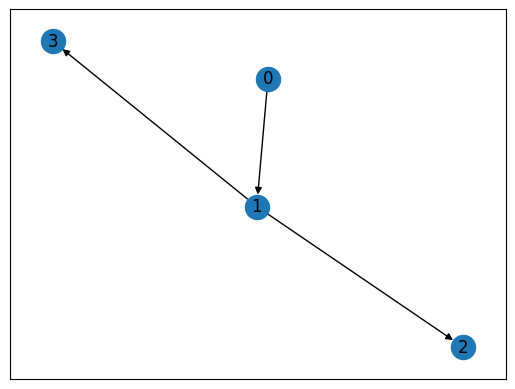

In [ ]:
import networkx as nx

# importing matplotlib.pyplot
import matplotlib.pyplot as plt

vis = to_networkx(final_train_dataset[30])



nx.draw_networkx(vis)
plt.show()

# **Training and Testing a GNN model**

Breaking data to trainset (80% of data) and testset (20% of data), also breaking each set to batches with size=128





Creating a model: a Graph Convlotional Network with 3 layers

Training and testing data in 50 epochs

In [ ]:
import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import global_mean_pool, MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import StepLR

# Assuming final_train_dataset is already defined
train_loader = DataLoader(final_train_dataset[:6000], batch_size=128, shuffle=True)
valid_loader = DataLoader(final_train_dataset[6000:6500], batch_size=128, shuffle=False)
test_loader = DataLoader(final_train_dataset[6500:], batch_size=128, shuffle=False)

class EnhancedCustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, decay_factor=0.5, number_of_hops=4):
        super(EnhancedCustomGCNConv, self).__init__(aggr='add')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.decay_factor = decay_factor
        self.number_of_hops = number_of_hops
        self.lin = Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        x_final = torch.zeros_like(x)
        x_degree = x
        for hop in range(1, self.number_of_hops):
            x_degree = self.propagate(edge_index, x=x_degree, norm=norm)
            x_final += (self.decay_factor ** hop) * x_degree
        return x_final

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

    def __repr__(self):
        return f'{self.__class__.__name__}(in_channels={self.in_channels}, out_channels={self.out_channels}, decay_factor={self.decay_factor})'

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=64, decay_factor=0.6, dropout=0.5, number_of_hops=4):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = EnhancedCustomGCNConv(len(final_train_dataset[0]['x'][0]), hidden_channels, decay_factor, number_of_hops)
        self.conv2 = EnhancedCustomGCNConv(hidden_channels, hidden_channels, decay_factor, number_of_hops)
        self.conv3 = EnhancedCustomGCNConv(hidden_channels, hidden_channels, decay_factor, number_of_hops)
        self.lin = Linear(hidden_channels, 2)
        self.dropout = Dropout(p=dropout)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

def augment_data(dataset):
    augmented_data = []
    for data in dataset:
        perturbed_data = data.clone()
        perturbed_data.x += 0.01 * torch.randn_like(perturbed_data.x)
        augmented_data.append(perturbed_data)
    return augmented_data

# Training and testing functions
def train(model, optimizer, criterion):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

param_grid = {
    'hidden_channels': [32,64,128],
    'number_of_hops': [3,4,5],
    'decay_factor': [0.6, 0.65, 0.55],
    'learning_rate': [0.01],
    'weight_decay': [0],
    'dropout': [0.3, 0.5, 0]
}

save_path = '/content/drive/MyDrive/Graph-Neural-Network/modelsParams/CSLOG1-1/threeLayerEnhancedCustomGCNConv-directed-64-withCycle-withoutDropOut-oneHotEncoded-batchSize128-decayFactor0.5-lr0.01.pth'

best_valid_acc = 0
patience = 10

for params in ParameterGrid(param_grid):
    model = GCN(hidden_channels=params['hidden_channels'], decay_factor=params['decay_factor'], dropout=params['dropout'], number_of_hops=params['number_of_hops'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()

    trigger_times = 0
    for epoch in range(50):
        train(model, optimizer, criterion)
        valid_acc = test(model, valid_loader)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_params = params
            torch.save(model.state_dict(), save_path)
            trigger_times = 0
        else:
            trigger_times += 1

        print(f'Params: {params}, Epoch: {epoch:03d}, Valid Acc: {valid_acc:.4f}')

        if trigger_times >= patience:
            print('Early stopping!')
            break

print(f'Best params: {best_params}, Best Valid Acc: {best_valid_acc:.4f}')

# Load best model and test
best_model = GCN(hidden_channels=best_params['hidden_channels'], decay_factor=best_params['decay_factor'], dropout=best_params['dropout'], number_of_hops=best_params['number_of_hops'])
best_model.load_state_dict(torch.load(save_path))

def ensemble_test(models, loader):
    for model in models:
        model.eval()
    correct = 0
    for data in loader:
        outputs = [model(data.x, data.edge_index, data.batch) for model in models]
        out = torch.mean(torch.stack(outputs), dim=0)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# Create ensemble of best models
models = [GCN(hidden_channels=best_params['hidden_channels'], decay_factor=best_params['decay_factor'], dropout=best_params['dropout'], number_of_hops=best_params['number_of_hops']) for _ in range(5)]
for model in models:
    model.load_state_dict(torch.load(save_path))

ensemble_test_acc = ensemble_test(models, test_loader)
print(f'Ensemble Test Acc: {ensemble_test_acc:.4f}')


Params: {'decay_factor': 0.6, 'dropout': 0.3, 'hidden_channels': 32, 'learning_rate': 0.01, 'number_of_hops': 3, 'weight_decay': 0}, Epoch: 000, Valid Acc: 0.7240
Params: {'decay_factor': 0.6, 'dropout': 0.3, 'hidden_channels': 32, 'learning_rate': 0.01, 'number_of_hops': 3, 'weight_decay': 0}, Epoch: 001, Valid Acc: 0.8040
Params: {'decay_factor': 0.6, 'dropout': 0.3, 'hidden_channels': 32, 'learning_rate': 0.01, 'number_of_hops': 3, 'weight_decay': 0}, Epoch: 002, Valid Acc: 0.7880
Params: {'decay_factor': 0.6, 'dropout': 0.3, 'hidden_channels': 32, 'learning_rate': 0.01, 'number_of_hops': 3, 'weight_decay': 0}, Epoch: 003, Valid Acc: 0.7800
Params: {'decay_factor': 0.6, 'dropout': 0.3, 'hidden_channels': 32, 'learning_rate': 0.01, 'number_of_hops': 3, 'weight_decay': 0}, Epoch: 004, Valid Acc: 0.7800
Params: {'decay_factor': 0.6, 'dropout': 0.3, 'hidden_channels': 32, 'learning_rate': 0.01, 'number_of_hops': 3, 'weight_decay': 0}, Epoch: 005, Valid Acc: 0.7700
Params: {'decay_factor